In [126]:
import sys
from typing import Iterable
from gelidum import freeze

import matplotlib.pyplot as plt

def not_implemented(cls, *args, **kwargs):
    raise NotImplementedError

class RemoveMethods(type):
    def __new__(mcls, name, bases, attrs):
        cls = super().__new__(mcls, name, bases, attrs)
        builtins_to_deactivate = {"__add__","__radd__", "append", "extend", "insert", "pop", "reverse", "sort", "__contains__", "remove", "__delitem__", "__iter__", "__len__" }
        for method in builtins_to_deactivate  - attrs.keys():
            setattr(cls, method, not_implemented)
        return cls

In [127]:
sys.setrecursionlimit(15_000)

# Introduction

> Deux amis de longue date, Bric et Brac, ont ouvert deux librairies concurrentes.
> 
> Bric dispose d'une grande étagère, qui permet de ranger chaque livre dans un emplacement dédié.
>
> De son coté, Brac a ouvert sa librarie à coté d'un grand trou, qu'il compte utiliser pour stocker ses livres en les attachant avec une corde.

Dans ce TD, nous allons donc étudier différentes stratégies de rangement de livres. On utilisera des chaînes de caractères pour représenter les livres: par exemple `"abcdef"` représentera un livre dont le titre est `"abcdef"`.

Pour ce faire, nous allons définir des structures de données très simples. Le but est de manipuler et d'étudier ces structures de données, afin de nous permettre faire d'obtenir les propriétés désirées en terme de:

- utilisation CPU (i.e. temps de calcul)
- utilisation mémoire (i.e. quantité de RAM utilisée)

# Librairie de Bric

## Étagère

### Définition 
<div style="float: right">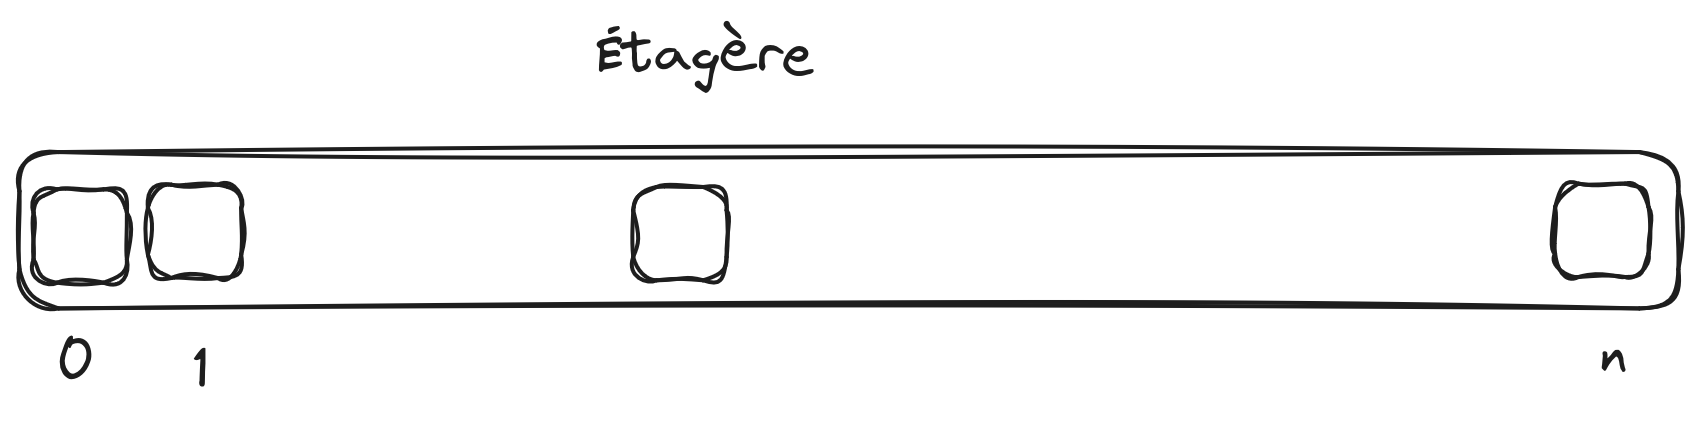</div>

<!-- 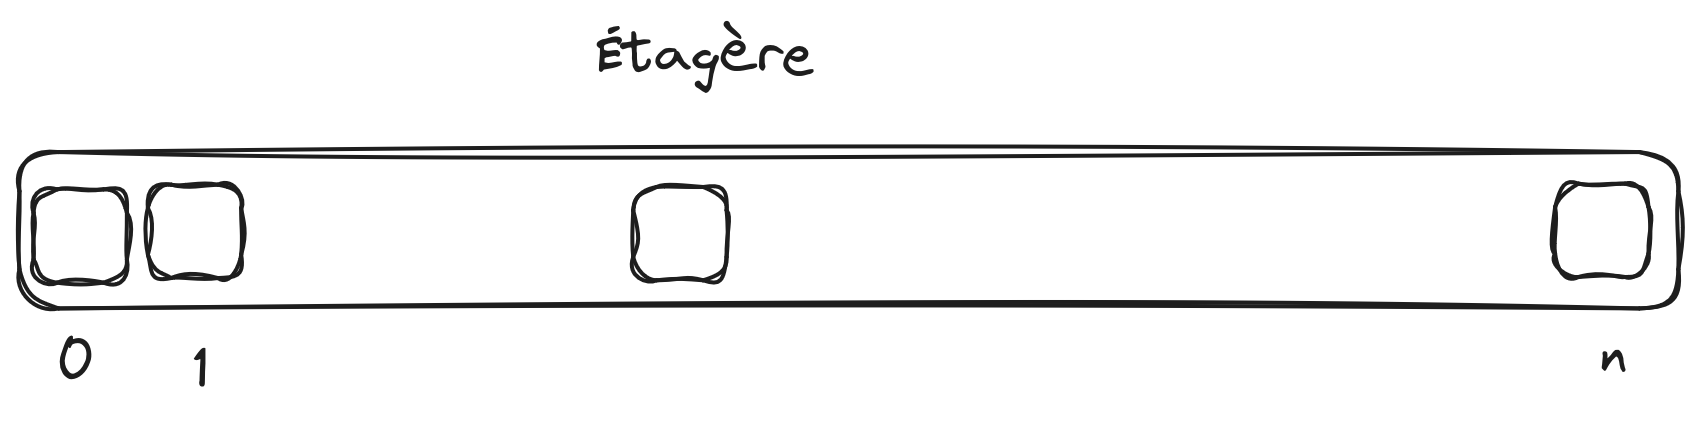 -->

Une étagère permet de ranger des éléments, et à accéder à chacun d'entre eux immédiatement.

Une fois qu'une étagère a été construite, on ne peut plus modifier sa taille.

**Note:** on utilisera la valeur `None` pour désigner un emplacement vide.

In [155]:
class Étagère(list[str], metaclass=RemoveMethods):
    """Classe pour une étagère. Il n'y a pas besoin de s'intéresser au code."""
    def __init__(self, capacité: int):
        super().__init__([None] * capacité)
        self.capacité = capacité
        
    def _repr_html_(self):
        def row(values):
            return "".join(f"<td>{value}</td>" for value in values)
        return f"""
        <style> table, th, td {{ border: 1px solid black !important; }} </style>
        <table>
            <tr><th>indice</th>{row(range(self.capacité))}</tr>
            <tr><th>valeur</th>{row(self[i] for i in range(self.capacité))}</tr>
        </table>
        """


### Exemples

In [157]:
# Instantiation: on crée une étagère avec 5 emplacements
a = Étagère(5)
a

indice,0,1,2,3,4
valeur,None,None,None,None,None


In [158]:
# accès à un élément
print(a[3])

None


In [159]:
# Modification d'un élément
a[3] = 2
a[3]

2

In [160]:
a

indice,0,1,2,3,4
valeur,None,None,None,2,None


## Librairie de Bric

Bric emploie une méthode simple pour ranger ses livres: à chaque fois qu'il reçoit un nouveau livre, il le range au premier emplacement vide.

### Exercice

Compléter les méthodes suivantes de la classe `Array`:

In [84]:
class LibrarieDeBric(:
    def __init__(self, capacité: int = 1000):
        self.étagère = Étagère(capacité)

    def nb_livres(self) -> int:
        """Nombre d'éléments du tableau qui ne sont pas None"""
        #BEGIN
        res : int = 0
        for i in range(self.capacité):
            if self[i] is not None:
                res += 1
        return res
        #END

    def ajout_livre(self, value: str):
        """
        Ajoute value dans la première case libre du tableau
        Lève une exception si plus de place
        """
        #BEGIN
        for i in range(self.capacité):
            if self[i] is None:
                self[i] = value
                return
        raise Exception("Plus de place")
        #END

    def remove(self, value):
        """
        Supprime la première case égale à value
        Lève une exception si pas trouvée
        """
        #BEGIN
        for i in range(self.capacité):
            if self[i] == value:
                self[i] = None
                return
        raise Exception("Pas trouvé")
        #END

    @staticmethod
    def from_values(values):
        res = Array(capacité=2*len(values))
        for i, value in enumerate(values):
            res.insert(value)
        return res

### Vérifications

In [85]:
a = Array.from_values([1, 3, 5])
assert a[0] == 1 and a[1] == 3 and a[2] == 5 and a[3] == None
display(a)
print("On insère 2 dans a")
a.insert(2)
assert a[3] == 2
display(a)
print("On supprime 3 de a")
a.remove(3)
assert a[1] is None
a


indice,0,1,2,3,4,5
valeur,1,3,5,None,None,None


On insère 2 dans a


indice,0,1,2,3,4,5
valeur,1,3,5,2,None,None


On supprime 3 de a


indice,0,1,2,3,4,5
valeur,1,None,5,2,None,None


j
k$l;*mûhùji*kl;m
*$ù!# Liste

## Définition
Une liste est un ensemble d'éléments, où chaque élément contient une valeur, et peut être relié à un élément suivant.

<!-- 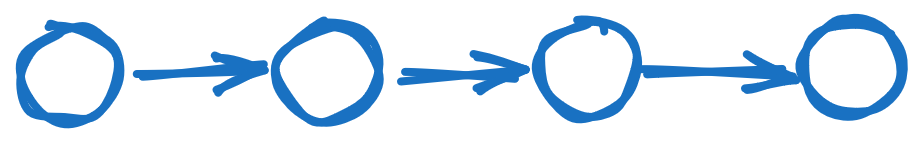 -->

<div>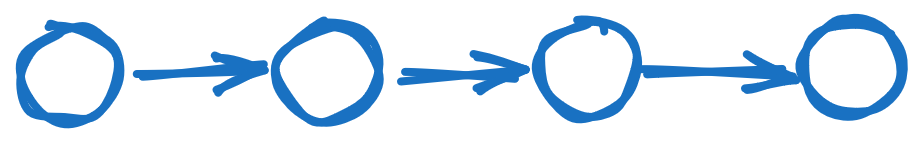</div>


Voici une implémentation minimale d'une classe Liste:

In [86]:
class List:
    # __slots__ = ("value", "next", "is_empty")
    def __init__(self):
        self.is_empty = True

    @staticmethod
    def create_element(value, next=None):
        res = List()
        res.is_empty = False
        res.value = value
        if next is not None:
            res.next = next
        else:
            res.next = List()
        return res
        
    def _repr_html_(self):
        if self.is_empty:
            return "■"
        return str(self.value) + " ⟶ " + self.next._repr_html_()

    def __eq__(self, other):
        if not isinstance(other, List):
            return False

        if self.is_empty or other.is_empty:
            return self.is_empty == other.is_empty
        if self.value != other.value:
            return False
        return self.next == other.next

    def __radd__(self, value):
        if isinstance(value, List):
            raise NotImplementedError
        res = List()
        res.value = value
        res.next = self
        res.is_empty = False
        return res

In [87]:
EMPTY = freeze(List());
EMPTY

In [88]:
EMPTY == List()

True

In [89]:
(3 + EMPTY)

In [90]:
2 + (3 + EMPTY)

In [91]:
2 + (3 + EMPTY) == 2 + (3 + EMPTY)

False

In [92]:
List.create_element(4)

## Exercices 

Enrichir la classe liste avec les opérations suivantes:

In [98]:
class List(List):
    def nb_elements(self):
        if self.is_empty:
            return 0
        return 1 + self.next.nb_elements()
    
    def __contains__(self, value: str) -> bool:
        """Renvoie True si value est dans la liste, False sinon"""
        #BEGIN
        if self.is_empty:
            return False
        if self.value == value:
            return True
        return value in self.next
        #END
    
    def insert(self, pos: int, value: str) -> List:
        """Insère value à la position pos"""
        assert pos >= 0
        if pos == 0:
            if self.is_empty:
                self.value = value
                self.next = List()
                self.is_empty = False    
            else:
                new_next = List.create_element(self.value, self.next)
                self.value = value
                self.next = new_next
        else:
            self.next.insert(pos -1, value)

    def remove(self, pos: int) -> List:
        """Supprime l'élément à la position pos"""
        assert pos >= 0
        #BEGIN
        if pos == 0:
            if self.is_empty:
                raise ValueError
            self.value = self.next.value
            self.next = self.next.next
        else:
            self.next.remove(pos - 1)
        #END
    
    @staticmethod
    def from_values(values):
        res = List()
        for value in values:
            res.insert(0, value)
        return res

In [99]:
l = List()
l.insert(0, 4)
display(l)
l.insert(0, 5)
display(l)
l.insert(1, 3)
display(l)
l.nb_elements()

3

In [95]:
3 in l

True

In [96]:
6 in l

False

In [30]:
l.remove(1)
l

# Problème

Deux libraires concurrents veulent créer une base de données de leurs livres. Pour cela, l'un veut utiliser une liste, l'autre un tableau.

La base de données servira à connaître rapidement si un livre est disponible ou non. Régulièrement, des livres seront ajoutés, et les peuvent aussi être vendus.

Quelle base de données sera la plus rapide pour effectuer ces opérations ?

**Instruction:** Mesurer les temps pour
- ajouter un livre
- savoir si un livre est dans la librairie

pour des librairies de taille 1000, 2000, 5000 et 10000

In [ ]:
import time
import random
import string

def random_title(length: int):
    return "".join(random.choice(string.ascii_letters) for _ in range(length))


all_books = [random_title(10) for _ in range(10_000)]
to_insert = [random_title(10) for _ in range(100)]
to_search = [random_title(10) for _ in range(100)]

def make_list(size: int):
    return List.from_values(initial_data[0:size])

def make_array(size: int):
    return Array.from_values(initial_data[0:size])

In [ ]:
def benchmark_insert(Klass, nb_livres: int):
    librairie = Klass.from_values(all_books[0:nb_livres])
    
    start_time = time.perf_counter()
    for value in to_insert:
        librairie.insert(0, value)
    end_time = time.perf_counter()

    print(f"({nb_livres}, {end_time - start_time}), # insertion {Klass.__name__}")

def benchmark_contains(Klass, nb_livres: int):
    librairie = Klass.from_values(all_books[0:nb_livres])

    start_time = time.perf_counter()
    for value in to_search:
        value in librairie
    end_time = time.perf_counter()

    print(f"({nb_livres}, {end_time - start_time}), # recherche {Klass.__name__}")
        
        

In [ ]:
benchmark_insert(List, 1000)
benchmark_insert(List, 2000)
benchmark_insert(List, 5000)
benchmark_insert(List, 10000)

In [ ]:
benchmark_insert(Array, 1000)
benchmark_insert(Array, 2000)
benchmark_insert(Array, 5000)
benchmark_insert(Array, 10000)

In [ ]:
def affiche_valeurs(titre: str = None, **kwargs: list[tuple[int, int]]):
    """Affiche les valeurs passées en argument"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    for name, values in kwargs.items():
        xs = [value[0] for value in values]
        ys = [value[1] for value in values]
        ax.plot(xs, ys, "o-", label=name)
    fig.legend()
    ax.grid()
    ax.set_xlabel("Taille de l'entrée")
    ax.set_ylabel("Temps d'exécution (s)")
    if titre is not None:
        ax.set_title(titre)

In [ ]:

affiche_valeurs(
    titre="Temps pour 100 insertions",
    liste=(
(1000, 3.711800673045218e-05), # insertion List
(2000, 8.625599730294198e-05), # insertion List
(5000, 3.944999480154365e-05), # insertion List
(10000, 3.821800055447966e-05), # insertion List
    ),
    array=(
(1000, 0.015094153000973165), # insertion Array
(2000, 0.030815688995062374), # insertion Array
(5000, 0.07496714200533461), # insertion Array
(10000, 0.15300821499840822), # insertion Array
    )
)

In [ ]:
benchmark_contains(List, 1000)
benchmark_contains(List, 2000)
benchmark_contains(List, 5000)
benchmark_contains(List, 10000)

In [ ]:
benchmark_contains(Array, 1000)
benchmark_contains(Array, 2000)
benchmark_contains(Array, 5000)
benchmark_contains(Array, 10000)

In [ ]:
affiche_valeurs(
    titre="Temps pour 100 recherches",
    liste=(
(1000, 0.014344584007631056), # recherche List
(2000, 0.02990555299038533), # recherche List
(5000, 0.06645613399450667), # recherche List
(10000, 0.21083943199482746), # recherche List
    ),
    array=(
(1000, 0.007048465005937032), # recherche Array
(2000, 0.01569576800102368), # recherche Array
(5000, 0.03817352600162849), # recherche Array
(10000, 0.07036486100696493), # recherche Array  
    )
)